In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn import svm

from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import sys
import time
import zlib

In [3]:
#Read in the data
def create_input(path,File):
    df = pd.DataFrame()
    for file in File:
        if(file == 'bot.json'):
            print(path+file)
            temp = pd.read_json(path+file)
            temp['label'] = 1
            df = pd.concat([df,temp])
            print(df)
        else:
            print(path+file)
            temp = pd.read_json(path+file)
            temp['label'] = 0
            df = pd.concat([df,temp])
    return df
    
path = '../../PAN-19/prepared_dataset/'
File=['human_female.json','human_male.json','bot.json']

In [4]:
twitter_train = create_input(path+'training/en/',File)
twitter_test = create_input(path+'testing/en/', File)
twitter_train_es = create_input(path+'training/es/',File)
twitter_test_es = create_input(path+'testing/es/', File)
ds = pd.concat([twitter_train,twitter_test],ignore_index=True)

../../PAN-19/prepared_dataset/training/en/human_female.json
../../PAN-19/prepared_dataset/training/en/human_male.json
../../PAN-19/prepared_dataset/training/en/bot.json
                                    id  URL  mention  emoji  \
0     4d9645d3dfb31b0e120c0f1669d889c1    0       50     17   
1     282b0c263b2aa1eda81745c08b910d09    0       57     30   
2     84fd6d460407733a56c8cfae8df7eb50   13       84     47   
3     80ec7b0a607f3c3d2510105029efaf0f    0       79     27   
4     427fb617361c4f509d8831f36335e002    2       94     28   
...                                ...  ...      ...    ...   
2055  18c3c9accef72c5f8c26c6b94f31e6fc    0       27      5   
2056  decb8549a7274ceeceb8fb15f0db90b2    0       23      5   
2057  2c515694146bb39faddc295e107fe332    0       29      8   
2058  24f037ecfa99908432c9c9860a6cfd8d    2       29      5   
2059  721081fcb575173e3268d45abdc59a19   16       30      7   

                                                 tweets  label  
0     [I'

In [5]:
ds.head

<bound method NDFrame.head of                                     id  URL  mention  emoji  \
0     4d9645d3dfb31b0e120c0f1669d889c1    0       50     17   
1     282b0c263b2aa1eda81745c08b910d09    0       57     30   
2     84fd6d460407733a56c8cfae8df7eb50   13       84     47   
3     80ec7b0a607f3c3d2510105029efaf0f    0       79     27   
4     427fb617361c4f509d8831f36335e002    2       94     28   
...                                ...  ...      ...    ...   
6755  562cce18c66188147f68ca3503d29703  174        0    204   
6756  11b713898d701faf8a63615458e1fe27  190        0    230   
6757  c39e250c8f25b158f6f68f9256feec4e  176        0    265   
6758  70f01606bf62c3cd59fa7e884d9e95ec  172        0    255   
6759  fd1e616254dd5e00330fc429c0069688  187        0    206   

                                                 tweets  label  
0     [I'm sure I've been ill for about 2 months now...      0  
1     [What the hell is going on?! #CBB, This child ...      0  
2     [What's the 

In [6]:
# generate a digit DNA for each account 
def create_dna_from_tweets(tweets):
    dna = ''
    if not tweets:
        return dna
    for index, row in enumerate(tweets):
        # retweet
        if row.startswith('RT'):
            dna += 'T'
        # reply
        elif row.startswith('@'):
            dna += 'C'
        # tweet
        else:
            dna += 'A'
    return dna

In [7]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

In [8]:
#map dna to tweeter id
ds['dna'] = ds.apply(lambda x: create_dna_from_tweets(x['tweets']),axis=1)


In [9]:
# DNA string compression
dna_compressed = compress_dna_df(ds['dna'])
print(dna_compressed)

      original_dna_size  compressed_dna_size  compression_ratio
0                   133                   73           1.821918
1                   133                   81           1.641975
2                   133                   74           1.797297
3                   133                   79           1.683544
4                   133                   85           1.564706
...                 ...                  ...                ...
6755                133                   45           2.955556
6756                133                   45           2.955556
6757                133                   45           2.955556
6758                133                   45           2.955556
6759                133                   45           2.955556

[6760 rows x 3 columns]


In [10]:
# concat dna_compressed with twitter_ids df
dna_compressed = pd.concat([ds['dna'],ds['mention'],ds['emoji'],ds['URL'],dna_compressed,ds['label']],axis=1)
print(dna_compressed)


                                                    dna  mention  emoji  URL  \
0     AATAAAAAAAAAAAAAAAAAATTAAAAACTAAAATAAACAAAAATA...       50     17    0   
1     AAAATACCCAAAATAATAAAACACAAAAAAAAAAAAAAACAAAAAT...       57     30    0   
2     AAAAAACTAAAAACAACAAAAAACTAAAAACCTAAATAAAACTTAT...       84     47   13   
3     CAAAAAAATAAAAAATCAACCCACTATCAATAAAAAATCTAAACAA...       79     27    0   
4     AAAACTTAACACTAATCAACATCCCAACCAACACAACTACAAAAAA...       94     28    2   
...                                                 ...      ...    ...  ...   
6755  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...        0    204  174   
6756  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...        0    230  190   
6757  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...        0    265  176   
6758  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...        0    255  172   
6759  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...        0    206  187   

      original_dna_size  compressed_dna

In [11]:
# Filter genuine accounts and bot accounts to compute statistics for each group.
g = dna_compressed['label'] == 0
b = dna_compressed['label'] == 1

#### Compression statistics

In [12]:
compression_stats = pd.DataFrame({'Mean Length': [dna_compressed['dna'].apply(len).mean(), 
                                                  dna_compressed[g]['dna'].apply(len).mean(), 
                                                  dna_compressed[b]['dna'].apply(len).mean()],
                                  'SD Length': [dna_compressed['dna'].apply(len).std(), 
                                                dna_compressed[g]['dna'].apply(len).std(), 
                                                dna_compressed[b]['dna'].apply(len).std()],
                                  'Mean Uncompressed Size': [dna_compressed['original_dna_size'].mean(), 
                                                             dna_compressed[g]['original_dna_size'].mean(), 
                                                             dna_compressed[b]['original_dna_size'].mean()],
                                  'SD Uncompressed Size': [dna_compressed['original_dna_size'].std(), 
                                                            dna_compressed[g]['original_dna_size'].std(), 
                                                           dna_compressed[b]['original_dna_size'].std()],
                                  'Mean Compressed Size': [dna_compressed['compressed_dna_size'].mean(), 
                                                           dna_compressed[g]['compressed_dna_size'].mean(), 
                                                           dna_compressed[b]['compressed_dna_size'].mean()],
                                  'SD Compressed Size': [dna_compressed['compressed_dna_size'].std(), 
                                                         dna_compressed[g]['compressed_dna_size'].std(), 
                                                         dna_compressed[b]['compressed_dna_size'].std()],
                                  'Mean Compressio Ratio': [dna_compressed['compression_ratio'].mean(), 
                                                            dna_compressed[g]['compression_ratio'].mean(), 
                                                            dna_compressed[b]['compression_ratio'].mean()],
                                  'SD Compressio Ratio': [dna_compressed['compression_ratio'].std(), 
                                                          dna_compressed[g]['compression_ratio'].std(), 
                                                          dna_compressed[b]['compression_ratio'].std()]},
                                 index=['All', 'Genuine', 'Bot']).round(decimals=3)

In [13]:
print(compression_stats.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Mean Length &  SD Length &  Mean Uncompressed Size &  SD Uncompressed Size &  Mean Compressed Size &  SD Compressed Size &  Mean Compressio Ratio &  SD Compressio Ratio \\
\midrule
All     &        100.0 &        0.0 &                   133.0 &                   0.0 &                63.025 &              17.437 &                  2.281 &                0.621 \\
Genuine &        100.0 &        0.0 &                   133.0 &                   0.0 &                78.202 &               9.690 &                  1.735 &                0.285 \\
Bot     &        100.0 &        0.0 &                   133.0 &                   0.0 &                47.847 &               7.311 &                  2.826 &                0.308 \\
\bottomrule
\end{tabular}



#### Compression statistics visualization

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
findfont: Font family ['Source Sans Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Source Sans Pro'] not found. Falling back to DejaVu Sans.


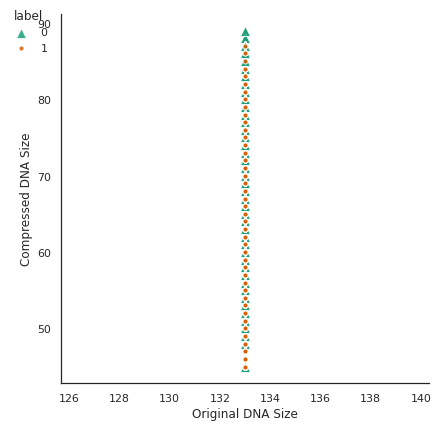

In [14]:
##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.
sns.set(style="white", font='Source Sans Pro')

pal = {
    0: sns.color_palette('Dark2')[0],
    1: sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_compressed, hue='label', palette=pal, size=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=100, alpha=0.85, edgecolor="white")
g.add_legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


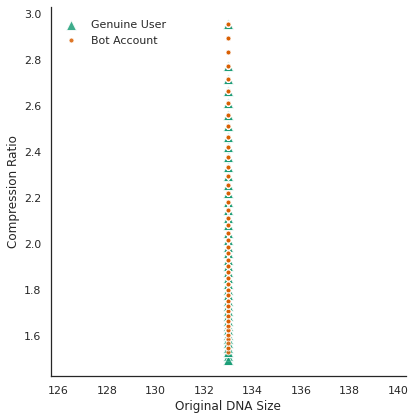

In [15]:
##### Plot of Uncompressed DNA Size vs. Compression Ratio.
sns.set(style="white", font='Source Sans Pro')

pal = {
    0: sns.color_palette('Dark2')[0],
    1: sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(dna_compressed, hue='label', palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=100, alpha=0.85, edgecolor="white")
g.add_legend(title='',bbox_to_anchor=(0.35, 0.95), loc=1, borderaxespad=0., labels=['Genuine User', 'Bot Account'])
g.set_axis_labels('Original DNA Size', 'Compression Ratio')
g.savefig('pan19_scatter.svg')

<AxesSubplot:xlabel='label', ylabel='compression_ratio'>

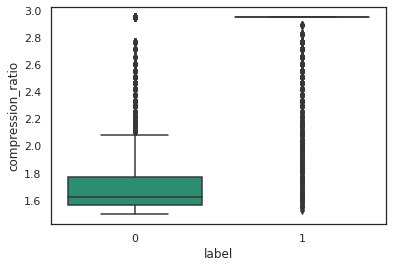

In [16]:
sns.boxplot(data=dna_compressed, x='label', y='compression_ratio', palette=pal, orient='v')

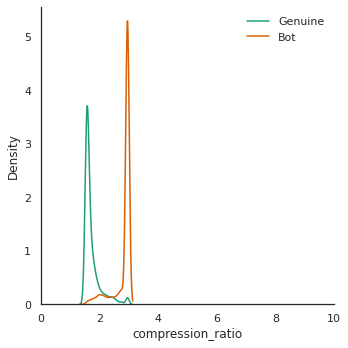

In [17]:
g = sns.FacetGrid(dna_compressed, hue='label', palette=pal, height=5)
g.set(xlim=(0, 10))
g.map(sns.kdeplot, 'compression_ratio')
plt.legend(loc='upper right', frameon=False, title='',labels=['Genuine', 'Bot'])
g.savefig('pan19_KDE.svg')

#### Train, predict and evaluate

In [18]:
def train_predict_evaluate(classifier, dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

In [19]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

#### Random forest classifier

In [20]:
rf_classifier = RandomForestClassifier(bootstrap=True,max_depth=5)
train_predict_evaluate(rf_classifier,dna_compressed,['original_dna_size', 'compressed_dna_size'])

,Metric,Score
0,Accuracy,0.915680
1,Precision,0.955177
2,Recall,0.876086
3,F1 Score,0.913923
4,MCC,0.834577
5,Specificity,0.957048


In [21]:
train_predict_evaluate(rf_classifier,dna_compressed,['original_dna_size', 'compression_ratio','mention',
                                                    'URL', 'emoji'])

,Metric,Score
0,Accuracy,0.959172
1,Precision,0.964976
2,Recall,0.952324
3,F1 Score,0.958608
4,MCC,0.918409
5,Specificity,0.965922


#### Gradient booster classifier



In [22]:

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)


In [23]:
train_predict_evaluate(gb_classifier,dna_compressed,['original_dna_size', 'compression_ratio'])

,Metric,Score
0,Accuracy,0.913905
1,Precision,0.947897
2,Recall,0.878929
3,F1 Score,0.912111
4,MCC,0.830244
5,Specificity,0.950060


In [24]:
train_predict_evaluate(gb_classifier,dna_compressed,['original_dna_size', 'compression_ratio','mention',
                                                    'URL', 'emoji'])

,Metric,Score
0,Accuracy,0.950000
1,Precision,0.954869
2,Recall,0.945326
3,F1 Score,0.950074
4,MCC,0.900048
5,Specificity,0.954735
